In [7]:
import pandas as pd
import spacy
import contextualSpellCheck
import re
nlp = spacy.load("en_core_web_sm")
contextualSpellCheck.add_to_pipe(nlp)
data_set = pd.read_csv('../data/blogtext.csv')

In [8]:
print(data_set.groupby('topic')['id'].count())

topic
Accounting                   3832
Advertising                  4676
Agriculture                  1235
Architecture                 1638
Arts                        32449
Automotive                   1244
Banking                      4049
Biotech                      2234
BusinessServices             4500
Chemicals                    3928
Communications-Media        20140
Construction                 1093
Consulting                   5862
Education                   29633
Engineering                 11653
Environment                   592
Fashion                      4851
Government                   6907
HumanResources               3010
Internet                    16006
InvestmentBanking            1292
Law                          9040
LawEnforcement-Security      1878
Manufacturing                2272
Maritime                      280
Marketing                    4769
Military                     3128
Museums-Libraries            3096
Non-Profit                  14700
Publishi

In [9]:
data_bio = data_set[data_set['topic']=='Biotech']
data = data_bio[['id', 'text', 'date']]
df = data[data.groupby('id')['id'].transform('size') > 50]
print(len(df.groupby('id')))


10


In [13]:
def get_trigram_features(pos_string):
    # Trigrams list
    # NVN NNV VNN NADPPROPN NNCCONJ NOUNPREPDET DETNOUNPREP VNV NNN  NOUNPREPNOUN VPREPDET
    features = {}
    features['nvn'] = len(re.findall('(NOUN VERB NOUN)', pos_string))
    features['nnv'] = len(re.findall('(NOUN NOUN VERB)', pos_string))
    features['vnn'] = len(re.findall('(VERB NOUN NOUN)', pos_string))
    features['vnv'] = len(re.findall('(VERB NOUN VERB)', pos_string))
    features['nap'] = len(re.findall('(NOUN ADP PROPN)', pos_string))
    features['nnc'] = len(re.findall('(NOUN NOUN CCONJ)', pos_string))
    features['nad'] = len(re.findall('(NOUN ADP DET)', pos_string))
    features['dna'] = len(re.findall('(DET NOUN ADP)', pos_string))
    features['nnn'] = len(re.findall('(NOUN NOUN NOUN)', pos_string))
    features['nan'] = len(re.findall('(NOUN ADP NOUN)', pos_string))
    features['vad'] = len(re.findall('(VERB ADP DET)', pos_string))
    
    return features 


closed_class = ['ADP','AUX','CCONJ','DET','NUM','PART','PRON','SCONJ']

ids = df['id'].unique()

mean_features = pd.DataFrame(columns=['id','spelling_errors', 'no_tag', 'sym', 'punct', 'nvn','nnv','vnn','vnv','nap','nnc','nad','dna','nnn','nan','vad'])
i = 0
for id in ids:
    if i == 1:
        break 
    i+=1 
    all_features = []
    for text in df.loc[df['id']==id, 'text']:
        
        tokenized = nlp(text)
        pos_only = []
        word_freq = {}
        for token in tokenized:
            pos_only.append(token.pos_)
            # print(token.lemma_, token.pos_, token.tag_)
            if token.lemma_ not in word_freq.keys():
                word_freq[token.lemma_] = 1
            else:
                word_freq[token.lemma_] += 1
                
        features = get_trigram_features(' '.join(pos_only))
        features['id']=id
        features['spelling_errors'] = len(tokenized._.suggestions_spellCheck)
        features['no_tag'] = pos_only.count('X')
        features['sym'] = pos_only.count('SYM')
        features['punct'] = pos_only.count('PUNCT')
        freq_sorted = dict(sorted(word_freq.items(), key=lambda item: item[1]))
        
        
        all_features.append(features)
    
    mean = pd.DataFrame(all_features)
    # print(mean)
    mean_features = mean_features.append(mean, ignore_index=True)
print(mean_features)

         id spelling_errors other_tag nvn nnv vnn vnv nap nnc nad dna nnn nan  \
0   3310475              11         0   1   0   0   0   0   1   0   0   0   0   
1   3310475               4         0   0   0   0   0   0   0   0   0   0   0   
2   3310475              14         0   0   0   0   0   0   1   3   5   1   3   
3   3310475              21         0   0   0   0   0   0   1   4   5   0   7   
4   3310475              16         0   0   0   1   0   0   0   0   0   0   0   
..      ...             ...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
60  3310475               6         0   1   0   0   1   0   0   1   3   0   6   
61  3310475              26         0   0   1   3   0   3   1   4   5   1   7   
62  3310475              21         0   1   0   0   0   0   0   5   3   0   2   
63  3310475               5         0   0   0   0   0   1   0   1   2   0   1   
64  3310475              22         0   0   0   0   0   1   2   4   7   0   6   

   vad  
0    1  
1    0  


In [24]:
i = 0
for text in df.loc[df['id']== 3310475, 'text']:
    if i == 3:
        break
    i += 1
    tokenized = nlp(text)
    print(len(tokenized._.suggestions_spellCheck))
    pos_only = []
    word_freq = {}
    for token in tokenized:
        if not token.text.isspace():
            pos_only.append(token.pos_)
            # print(token.lemma_, token.pos_, token.tag_)
            if token.lemma_ not in word_freq.keys():
                word_freq[token.lemma_] = 1
            else:
                word_freq[token.lemma_] += 1
            
    features = get_trigram_features(' '.join(pos_only))
    features['id']=id
    features['spelling_errors'] = len(tokenized._.suggestions_spellCheck)
    features['no_tag'] = pos_only.count('X')
    features['sym'] = pos_only.count('SYM')
    features['punct'] = pos_only.count('PUNCT')
    freq_sorted = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
        
        

11
4
14


In [27]:
print(freq_sorted)
prev = max(freq_sorted.values())
rank = 1
ranks = {}
sum_rank = 0
for word, freq in freq_sorted.items():
    if freq < prev:
        rank += 1
        prev = freq
    ranks[word] = rank
    sum_rank += rank
print(ranks)
print(sum_rank/len(ranks))

{'a': 16, 'be': 15, 'I': 15, 'on': 9, 'to': 8, 'it': 7, 'which': 6, 'you': 6, 'of': 5, 'do': 5, '.': 5, "'ve": 5, 'and': 5, 'for': 4, ',': 4, 'the': 4, 'if': 4, 'see': 4, 'again': 3, 'have': 3, "n't": 3, 'add': 3, 'get': 3, 'now': 3, 'that': 3, 'so': 3, 'everyone': 2, 'another': 2, 'an': 2, 'he': 2, 'today': 2, 'quite': 2, 'site': 2, 'still': 2, 'my': 2, 'can': 2, 'also': 2, 'forum': 2, 'use': 2, 'as': 2, 'go': 2, 'there': 2, 'link': 2, 'off': 2, '...': 2, 'work': 2, 'well': 2, "'ll": 2, 'we': 2, 'may': 2, 'while': 2, 'channel': 2, 'hilarious': 2, 'take': 2, 'hello': 1, 'daily': 1, 'installment': 1, 'bald': 1, "'s": 1, 'blog': 1, 'general': 1, 'idea': 1, 'what': 1, 'happen': 1, 'lot': 1, 'yes': 1, 'lease': 1, 'big': 1, 'update': 1, 'world': 1, 'angst': 1, 'at': 1, 'angelfire.com/vamp/woa': 1, 'chat': 1, 'server': 1, 'computer': 1, 'will': 1, 'ours': 1, 'hope': 1, 'more': 1, 'than': 1, 'few': 1, 'other': 1, 'know': 1, 'guestbook': 1, 'look': 1, 'shy': 1, 'couple': 1, 'thing': 1, 'includ

ValueError: x and y must be the same size

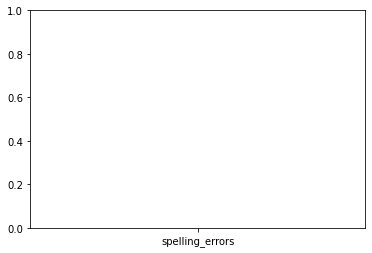

In [19]:

mean_features = mean_features.apply(pd.to_numeric)
mean_feat = mean_features.groupby('id').mean()


import matplotlib.pyplot as plt

mean_feat['id'] = mean_feat.index
ids = mean_feat['id'].unique()

plt.figure()

cols = mean_feat.columns[:-3]
for id in ids:
    plt.scatter(cols, mean_feat.loc[mean_feat['id']==id, mean_feat.columns != 'id'])

